<a href="https://colab.research.google.com/github/jgaucin03/CAIxIEEE-TinyML-Workshop/blob/main/IEEE_CAI_tinyml_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/sandeepmistry/aimldevfest-workshop-2019/master/images/Arduino_logo_R_highquality.png" width=200/></a>
# Tiny ML on Arduino
## Gesture recognition tutorial



https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

[original notebook](https://colab.research.google.com/github/arduino/ArduinoTensorFlowLiteTutorials/blob/master/GestureToEmoji/arduino_tinyml_workshop.ipynb)


## Setup Python Environment

The next cell sets up the dependencies in required for the notebook, run it.

In [ ]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow

# Upload Data

1. Open the panel on the left side of Colab by clicking on the __>__
1. Select the files tab
1. Drag `punch.csv` and `flex.csv` files from your computer to the tab to upload them into colab.

# Graph Data (optional)

We'll graph the input files on two separate graphs, acceleration and gyroscope, as each data set has different units and scale.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "punch_2.csv"

# We will use pandas library to work with the csv file
df = pd.read_csv("/content/" + filename)

In [ ]:
# priting the datasets
df

,aX,aY,aZ,gX,gY,gZ
0,-0.258,-2.290,-0.237,-123.06,-16.87,-280.56
1,-0.440,-2.187,-0.354,-100.10,-27.09,-366.45
2,-0.318,-1.664,0.391,22.61,-94.36,-399.91
3,-0.091,-1.304,0.675,22.75,-163.80,-424.13
4,-0.004,-0.746,0.558,-10.43,-215.53,-404.81
...,...,...,...,...,...,...
1302,0.212,-0.201,-0.944,-22.54,3.15,-32.90
1303,0.224,-0.197,-0.931,-19.74,3.01,-27.09
1304,0.217,-0.193,-0.914,-15.26,4.34,-20.37
1305,0.223,-0.234,-0.895,-10.50,5.11,-13.37


<ipython-input-9-5a2c472c73dd>:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
<ipython-input-9-5a2c472c73dd>:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
<ipython-input-9-5a2c472c73dd>:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')


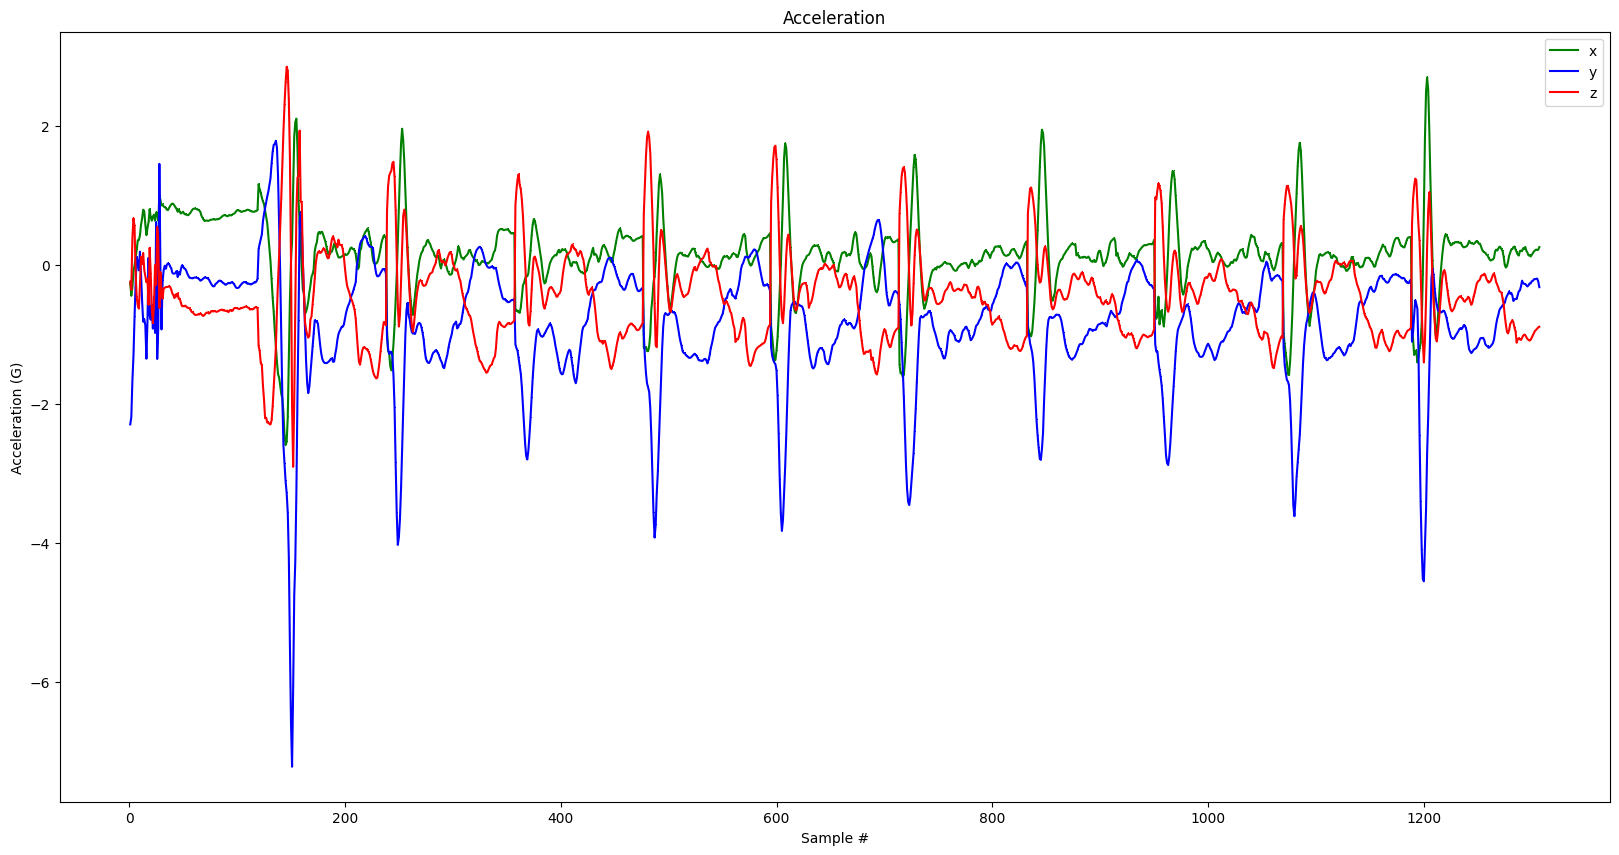

<ipython-input-9-5a2c472c73dd>:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
<ipython-input-9-5a2c472c73dd>:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
<ipython-input-9-5a2c472c73dd>:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')


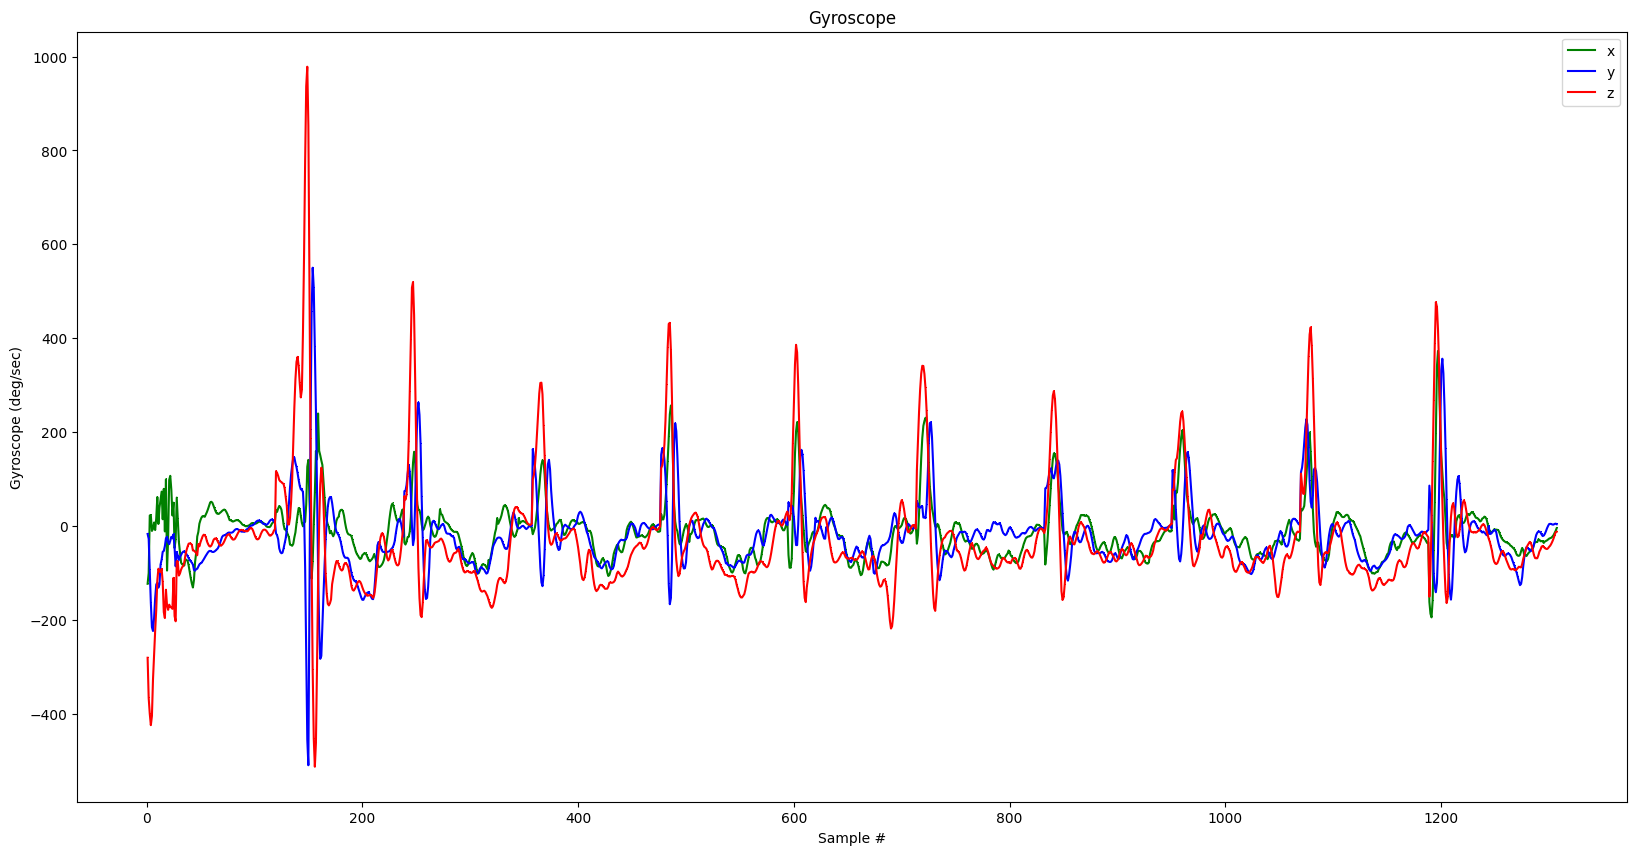

In [ ]:


index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()


From the plots we can see manually split the dataset into 10 punch samples

# Train Neural Network





## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

Update the `GESTURES` list with the gesture data you've collected in `.csv` format.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "punch",
    "flex",
]

# This is the number of sample we used while collecing the data
SAMPLES_PER_GESTURE = 119

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
# We use One-hot encoding to convert categorical variables into numerical values. This is useful for machine learning algorithms, which typically require numerical input and output variables
# One hot encoding creates a new representation of the categorical variable that is more informative for machine learning algorithms.
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)
# punch[1, 0] [0, 1]

inputs = []
outputs = []


# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")

  output = ONE_HOT_ENCODED_GESTURES[gesture_index]

  df = pd.read_csv("/content/" + gesture + "_2.csv")

  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")


  # In this step we are going to prepare the data in a form that the model accepts
  # Our input will be of shape (number of samples * features) (119 * 6 )
  # We also normalize the
  # Normalizing helps
    # improve convergence(help model learn faster),
    # Equalized features (out a* values are between -4 to 4 while g* are between -2000 to 2000)
    # Reduces overfitting

  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.13.0

Processing index 0 for gesture 'punch'.
	There are 10 recordings of the punch gesture.
Processing index 1 for gesture 'flex'.
	There are 10 recordings of the flex gesture.
Data set parsing and preparation complete.


In [ ]:
print('input_sample', inputs[0])

input_sample [0.46775   0.21375   0.470375  0.469235  0.4957825 0.42986   0.445
 0.226625  0.45575   0.474975  0.4932275 0.4083875 0.46025   0.292
 0.548875  0.5056525 0.47641   0.4000225 0.488625  0.337     0.584375
 0.5056875 0.45905   0.3939675 0.4995    0.40675   0.56975   0.4973925
 0.4461175 0.3987975 0.513     0.467375  0.48575   0.49846   0.4440875
 0.418415  0.52775   0.513875  0.44225   0.5018725 0.451035  0.4319425
 0.544875  0.507     0.427375  0.497865  0.461605  0.44414   0.545125
 0.490625  0.421875  0.50413   0.4688325 0.4552525 0.553625  0.52425
 0.46325   0.515435  0.4698125 0.4710025 0.57275   0.48475   0.51525
 0.5011025 0.46717   0.4772675 0.583875  0.43575   0.502125  0.5097475
 0.4689025 0.4758325 0.59975   0.398375  0.52175   0.5142275 0.4794725
 0.4755    0.596625  0.402625  0.4915    0.518305  0.48208   0.4771625
 0.573125  0.39175   0.48      0.503605  0.4862975 0.47011   0.554
 0.331875  0.46925   0.5197925 0.4867    0.45415   0.56675   0.400875
 0.474375  0

In [ ]:
print('Punch', outputs[0])
print('Flex', outputs[-1])

Punch [1. 0.]
Flex [0. 1.]


## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [ ]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
# We are using [60,20,20] for train, val and test
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

"""
Shuffling data in classification ensures balance, prevents sequence patterns, aids generalization, and enhances training by introducing randomness in mini-batches, resulting in a more accurate model.
"""

Data set randomization and splitting complete.


'\nShuffling data in classification ensures balance, prevents sequence patterns, aids generalization, and enhances training by introducing randomness in mini-batches, resulting in a more accurate model.\n'

## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In neural networks, activation functions are used to incorporate non-linearity into the output of a neuron. This is significant because it enables neural networks to learn complex input-output relationships.

The ReLU function is a very simple activation function that simply outputs the input if it is positive, and 0 otherwise. It is very efficient to compute and is often used in modern neural networks.

The softmax activation function is a mathematical function that converts a vector of real numbers into a probability distribution

In [ ]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=600, batch_size=1, validation_data=(inputs_validate, outputs_validate))



Epoch 1/600
12/12 [==============================] - 9s 31ms/step - loss: 0.5207 - mae: 0.5620 - val_loss: 0.4967 - val_mae: 0.4993
Epoch 2/600
12/12 [==============================] - 0s 11ms/step - loss: 0.4840 - mae: 0.4940 - val_loss: 0.2743 - val_mae: 0.4835
Epoch 3/600
12/12 [==============================] - 0s 12ms/step - loss: 0.4258 - mae: 0.5884 - val_loss: 0.2576 - val_mae: 0.4888
Epoch 4/600
12/12 [==============================] - 0s 10ms/step - loss: 0.3345 - mae: 0.5473 - val_loss: 0.2922 - val_mae: 0.4794
Epoch 5/600
12/12 [==============================] - 0s 13ms/step - loss: 0.3614 - mae: 0.5966 - val_loss: 0.2494 - val_mae: 0.4719
Epoch 6/600
12/12 [==============================] - 0s 19ms/step - loss: 0.3174 - mae: 0.5428 - val_loss: 0.2248 - val_mae: 0.4708
Epoch 7/600
12/12 [==============================] - 0s 18ms/step - loss: 0.2610 - mae: 0.4666 - val_loss: 0.2180 - val_mae: 0.4599
Epoch 8/600
12/12 [==============================] - 0s 13ms/step - loss: 0.

## Verify

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving.

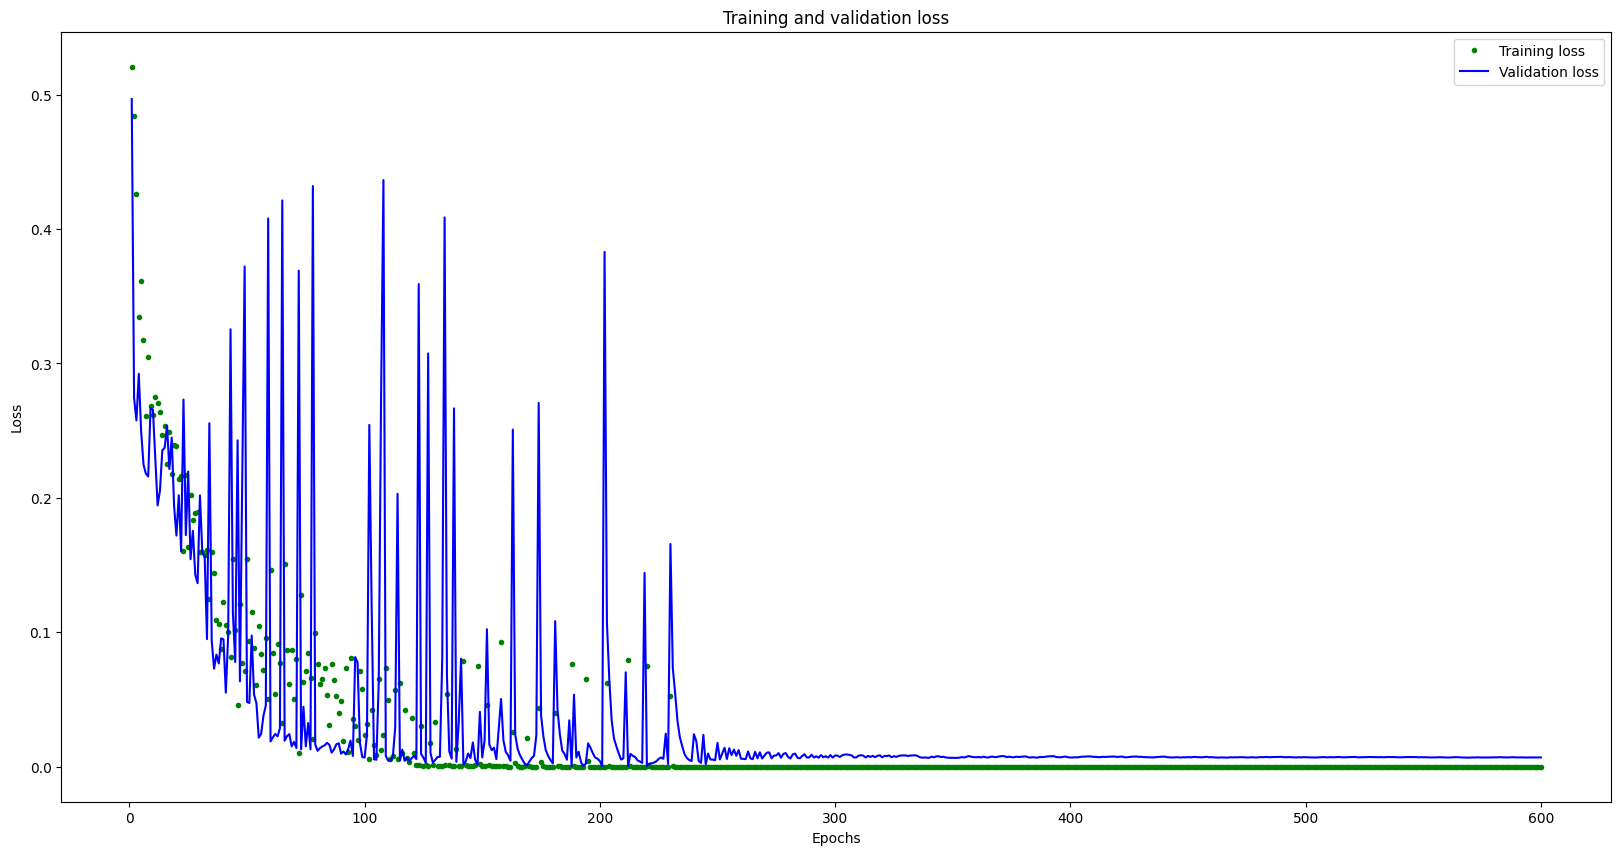

[20.0, 10.0]


In [ ]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Graph the loss again, skipping a bit of the start

We'll graph the same data as the previous code cell, but start at index 100 so we can further zoom in once the model starts to converge.

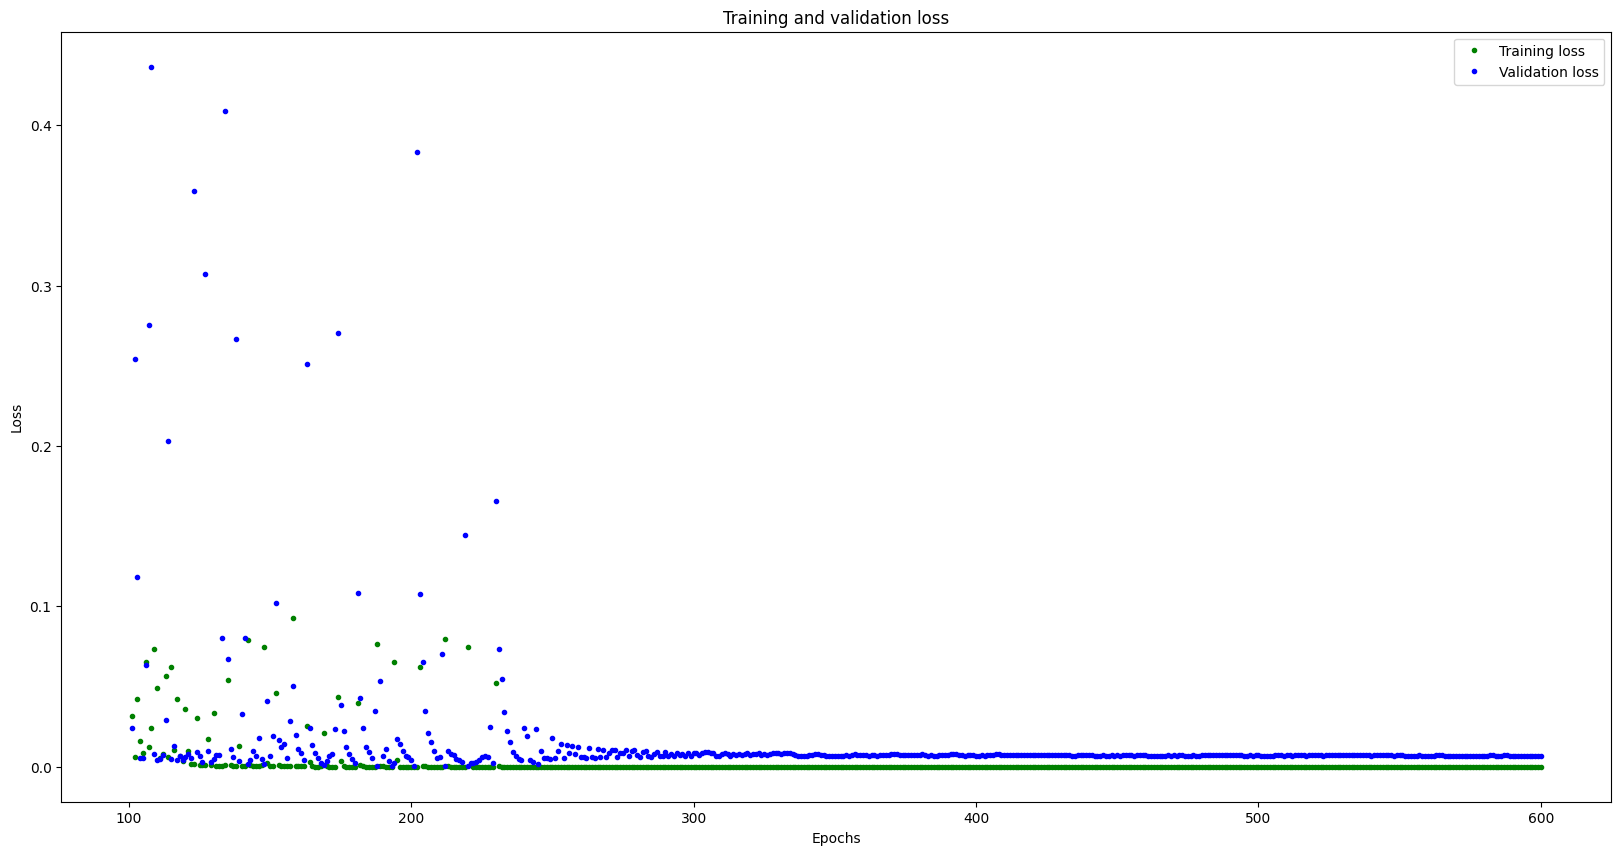

In [ ]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Graph the mean absolute error

[Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) is another metric to judge the performance of the model.



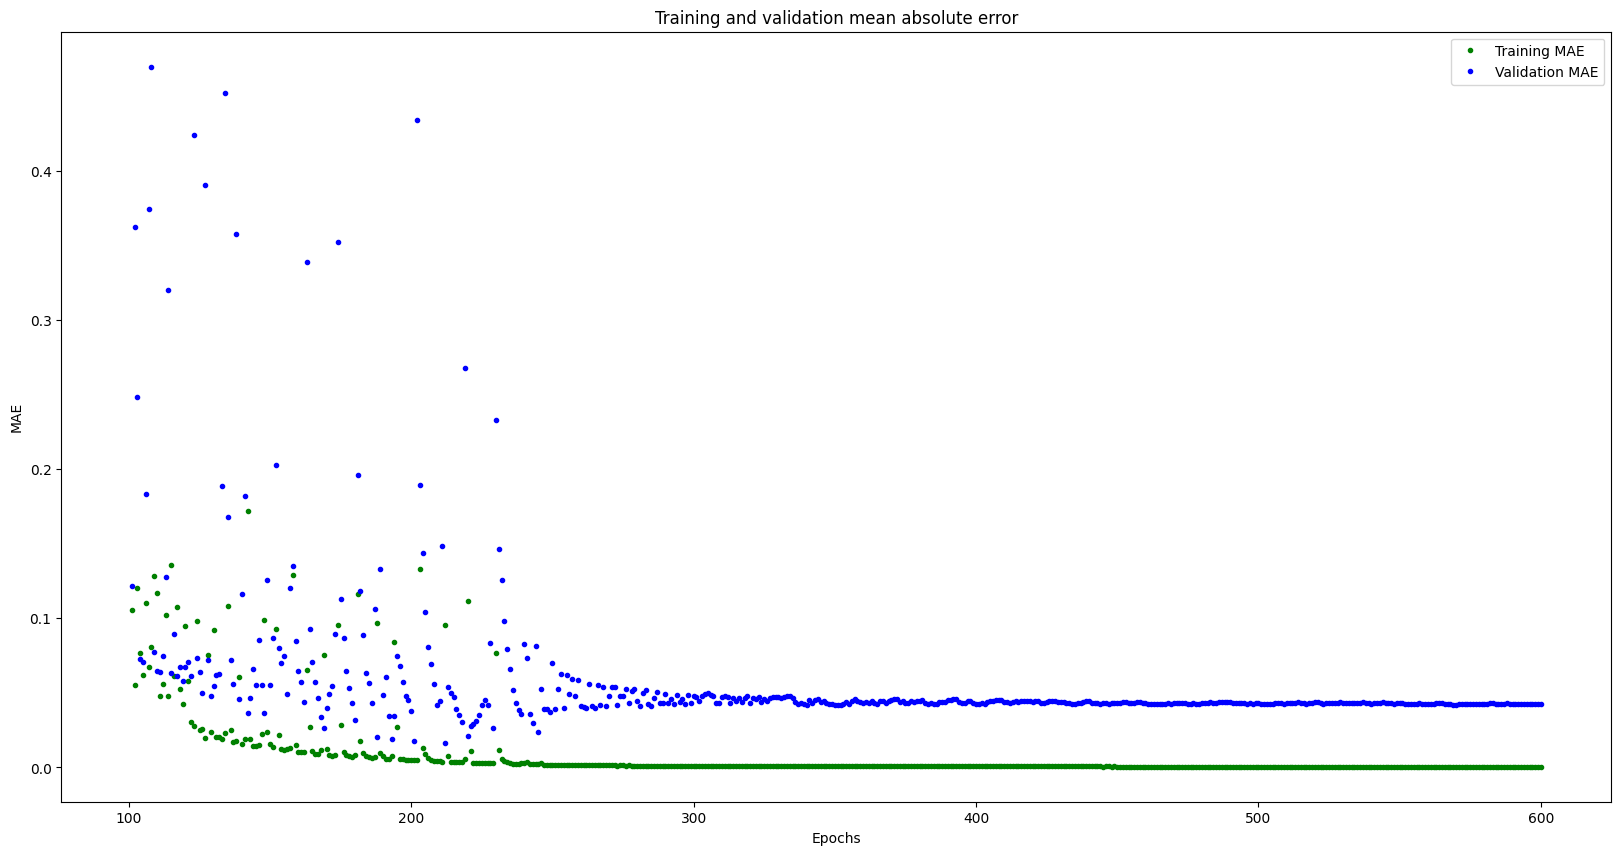

In [ ]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


### Run with Test Data
Put our test data into the model and plot the predictions


In [ ]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)




1/1 [==============================] - 0s 106ms/step
predictions =
 [[0.025 0.975]
 [0.012 0.988]
 [1.    0.   ]
 [0.999 0.001]]
actual =
 [[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)



Model is 148280 bytes


## Encode the Model in an Arduino Header File

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 914,428 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


# Classifying IMU Data

Now it's time to switch back to the tutorial instructions and run our new model on the Arduino Nano 33 BLE Sense to classify the accelerometer and gyroscope data.
